* Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All). Or, alternatively, **Restart & Run All**.

* Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE".

* You can always add additional cells to the notebook to experiment, to test your answers, or to provide additional support for your answers.

* You should not need to install new packages to complete an assignment. If you use any packages not available via the MATH405 `Project.toml` then your assignment will likely not be graded correctly.

* Submissions are only accepted via CANVAS!

* Late submissions: within 24h I will reduce the grade to 70%. I will not accept submissions after 24h. Please manage your time well and complete the assignments with plenty of buffer time.

* By entering your name below you confirm that you have completed this assignment on your own and without (direct) help from your colleagues. Plagiarism / copying will be checked by comparing assignments and by by testing understanding in workshops and the oral exam (final). I reserve the option to downgrade an assignment at any point.

In [2]:
NAME = "William Choi"

"William Choi"

---

# MATH 405/607 

# Numerical Methods for Differential Equations

## Assignment 2: Nonlinear systems, interpolation, quadrature


#### Notes

* I will start to be rigorous about following instructions precisely to enable the autograder to correctly read you answers. Please watch out for those instructions. If a solution is correct but is not stored in the correct variables I will only give partial points. 
* **Due date:** Wed 14 October 2020, 1200 noon
* 90 points (out of 125) will count for 100%

In [10]:
include("math405.jl")

 Activating environment at `~/Desktop/School Work/MATH405/assignments/A2/Project.toml`
┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1278
┌ Info: Precompiling OrdinaryDiffEq [1dea7af3-3e70-54e6-95c3-0bf5283fa5ed]
└ @ Base loading.jl:1278


### Question 1 [5+5]

Skim the `README` files of [`Roots.jl`](https://github.com/JuliaMath/Roots.jl) and of [NLsolve.jl](https://github.com/JuliaNLSolvers/NLsolve.jl) to understand what these packages are written for. Then use appropriate functions provided by these packages to solve the following nonlinear equations: 

(a) Find all solutions $x \in [0.1, 4.1\pi]$ of 
$$
    x^{-2} = \sin(x)
$$
Assign these to a vector as follows: `X_a = [ x1, x2, ... ]`

(b) Find the unique solution of the system  
$$\begin{aligned}
    & f(x) := \nabla \varphi(x) = 0,  \qquad \text{where} 
    & \varphi(x) = x_1^6 + \sum_{j = 2}^{10} (x_j - x_{j-1})^6 + x_{10}^6 -0.01 \sum_{j = 1}^{10} x_j.
\end{aligned}$$
and store it in the variable `xb` i.e. 

HINT: you need not derive and implement the gradient, but could use an AD package (e.g. `ForwardDiff.jl`) to obtain it from $\varphi$, e.g., 
```julia 
fb(x) = ForwardDiff.gradient(phi, x)
```

In [75]:
# Somewhere in this code you should have the lines 
#  Xa = [ ... ]
#  xb =  ...

# Part (a)
fa(x) = x^(-2)-sin(x)
Xa = find_zeros(fa, 0.1, 4.1*pi)
X_a = Xa # Just in case
println("Solutions to part (a) for x in [0.1,4.1*pi]")
println(Xa)

# Part (b)
phi(x) = x[1]^6 + sum((x[2:10] - x[1:9]).^6) + x[10]^6 - 0.01*sum(x[1:10])
function fb(grad, x)
    grad = ForwardDiff.gradient(phi, x)
end 

xb = nlsolve(fb, rand(10), autodiff=:forward)
println("Solution to part (b) for a random initial point")
println(xb.zero)

Solutions to part (a) for x in [0.1,4.1*pi]
[1.068223544197249, 3.032645418388756, 6.308316825268553, 9.413492803170099, 12.572696859373606]
Solution to part (b) for a random initial point
[0.3838519496373778, 0.7509497212223639, 1.0975221427999389, 1.4170993146380149, 1.6953074058551434, 1.695307401598543, 1.4170993146379984, 1.0975221427999362, 0.7509497212223628, 0.3838519496373775]


### Question 2 [10+5+10]

Newton's method is chaotic (cf Fractals) and in general converges only locally, or at least its global behaviour is unpredictable for most practical purposes. Most implementations of Newton's method therefore have some "globalisation" strategies, i.e. incorporate ideas (heuristic and rigorous) to improve global convergence properties, or at least increase make the behaviour more predictable. In this question we will explore one strategy of this kind. 

Suppose your current iterate is $x_n$ then the next iterate would be $x_{n+1} = x_n - \partial f(x_n)^{-1} f(x_n)$. But instead, let us define this increment as a *search vector*. That is, we define 
$$
    p_n := - \partial f(x_n)^{-1} f(x_n)
$$
and look for updates of the form 
$$
    x_{n+1} = x_n + \alpha_n p_n
$$
where $\alpha_n \in (0, 1]$.

(a+) Compute $\frac{d}{d\alpha} |f(x_n + \alpha p_n)|^2$ at $\alpha = 0$, then deduce that, for sufficiently small $\alpha$ the update $x_{n+1}$ satisfies
$$
  \text{(DEC)} \qquad   |f(x_{n+1})| \leq (1 - \alpha_n/2) |f(x_n)|
$$
You may use any regularity on $f$ that you need.

Remarks:
* In your proof you should find that the factor $1/2$ in $(1-\alpha/2)$ is somewhat arbitrary. But it is a sensible choice that seems to work quite well in the following tests.
* You can proceed to part (b) without answering this question.

(b) To achieve the (DEC) condition, we can use a backtracking algorithm. At each iterate $x_n$ our first guess should be $\alpha = 1$ to obtain quadratic convergence in the limit. If this fails the (DEC) condition, then we halve $\alpha$ until it is satisfied.
``` 
WHILE ||f(x + alpha p)|| > (1-alpha/2) * ||f(x)||
    alpha <- alpha / 2
```
* Implement this backtracking condition into a Newton iteration. 
* In light of part (a) of this question, terminate the backtracking with `return nothing` when $\alpha < 10^{-8}$.

In the code-cell below most of the two Newton methods have already been written. Only edit the part of the code that is indicated to incorporate the backtracking loop. Just translate the pseudocode into valid Julia code.

In [71]:

function newton(f, x0, tol, df = x -> ForwardDiff.jacobian(f, x); maxiter = 100)
    x = x0 
    it = 0
    while norm(f(x)) > tol 
        x -= df(x) \ f(x)
        it += 1; 
        if (it > maxiter) || any(isnan, x) || any(isinf, x)
            return nothing
        end
    end 
    return x, it 
end

function damped_newton(f, x0, tol, df = x -> ForwardDiff.jacobian(f, x); maxiter = 100)
    x = x0
    it = 0

    while norm(f(x), Inf) > tol 
        p = - (df(x) \ f(x))
        
        # --------- Backtracking loop 
        # YOUR CODE HERE
        # ---------------------------
        
        α = 1.0
        while(norm(f(x+α*p))) > (1-α/2.0)*norm(f(x))
            α = α/2.0
            
            if α < 10^-8
                return nothing
            end
        end
    
        x += α * p
        it += 1

        # for debugging!
        @show α, norm(f(x), Inf)

        if it > maxiter; return nothing; end 
    end
    return x, it 
end

damped_newton (generic function with 2 methods)

 This little test shows how Newton's method can converge 
 predictably or to vastly different solution
 while the damped Newton method usually converges predictably.
    
 Check that the damped Newton method always converges to the 
 root near 6.38.

Newton - Start guess 4.85:
   x = [6.380161895923983], #it = 7
Newton - Start guess 4.84:
   x = [28.90835078092175], #it = 7
Damped Newton - Start guess 4.85:
(α, norm(f(x), Inf)) = (0.5, 0.04766683141559086)
(α, norm(f(x), Inf)) = (1.0, 0.00029214550061143485)
(α, norm(f(x), Inf)) = (1.0, 2.2349452150072224e-8)
(α, norm(f(x), Inf)) = (1.0, 5.551115123125783e-17)
   x = [6.380161895923983], #it = 4
Damped Newton - Start guess 4.84:
(α, norm(f(x), Inf)) = (0.5, 0.04288619550399855)
(α, norm(f(x), Inf)) = (1.0, 0.00026004963647546786)
(α, norm(f(x), Inf)) = (1.0, 1.7714995248496734e-8)
(α, norm(f(x), Inf)) = (1.0, 5.551115123125783e-17)
   x = [6.380161895923983], #it = 4


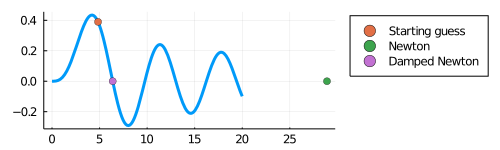

In [72]:
# you may edit this cell to experiment with your code ...

println("""
 This little test shows how Newton's method can converge 
 predictably or to vastly different solution
 while the damped Newton method usually converges predictably.
    
 Check that the damped Newton method always converges to the 
 root near 6.38.
""")

# wrapping a scalar problem into a vectorial one (with 1 dimension of course...)
fbes = x -> [besselj(3,x[1])]

println("Newton - Start guess 4.85:")
xn1, itn1 = newton(fbes, [4.85], 1e-10)
println("   x = $(xn1), #it = $(itn1)")

println("Newton - Start guess 4.84:")
xn2, itn2 = newton(fbes, [4.84], 1e-10)
println("   x = $(xn2), #it = $(itn2)")

println("Damped Newton - Start guess 4.85:")
xd1, itd1 = damped_newton(fbes, [4.85], 1e-10)
println("   x = $(xd1), #it = $(itd1)")

println("Damped Newton - Start guess 4.84:")
xd2, itd2 = damped_newton(fbes, [4.84], 1e-10)
println("   x = $(xd2), #it = $(itd2)")

plot(x->besselj(3,x), 0, 20, lw=3, label="", grid=:xy, size=(500,150), legend = :outertopright)
scatter!([4.84], fbes(4.84), label = "Starting guess")
scatter!(xn2, [0.0], label = "Newton")
scatter!(xd2, [0.0], label = "Damped Newton")

(c) Use both the Newton and damped Newton algorithms to solve the problem from Question 1, with starting guess `x0[i] = c * i * (11-i)` where `c in [0.01, 0.1]` and briefly comment on your observations. Use comments such as ,
```julia 
# we oberserve that `newton` ... while `damped_newton` ... 
```

In [74]:
# YOUR CODE HERE
phi(x) = x[1]^6 + sum((x[2:10] - x[1:9]).^6) + x[10]^6 - 0.01*sum(x[1:10])
function fb(x)
    return ForwardDiff.gradient(phi, x)
end 

# Declaring initial conditions
c = 0.05
x0_b = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
x0_b = c.*x0_b.*(-x0_b.+11.0)

println("Newton - Start guess 4.84:")
xn2, itn2 = newton(fb, x0_b, 1e-10)
println("   x = $(xn2), #it = $(itn2)")

println("Damped Newton - Start guess x0:")
xd2, itd2 = damped_newton(fb, x0_b, 1e-10)
println("   x = $(xd2), #it = $(itd2)")


Newton - Start guess 4.84:
   x = [0.3838519496373775, 0.7509497212223628, 1.097522142799936, 1.4170993146379969, 1.6953074016292615, 1.6953074016292615, 1.4170993146379969, 1.097522142799936, 0.7509497212223628, 0.3838519496373775], #it = 16
Damped Newton - Start guess x0:
(α, norm(f(x), Inf)) = (0.0625, 0.10895072523985118)
(α, norm(f(x), Inf)) = (0.5, 0.06248034927143153)
(α, norm(f(x), Inf)) = (1.0, 0.014578871989772058)
(α, norm(f(x), Inf)) = (1.0, 0.001383589519038721)
(α, norm(f(x), Inf)) = (1.0, 1.4976407030424868e-5)
(α, norm(f(x), Inf)) = (1.0, 1.793825888177225e-9)
(α, norm(f(x), Inf)) = (1.0, 2.949029909160572e-17)
   x = [0.3838519496373775, 0.7509497212223628, 1.097522142799936, 1.4170993146379969, 1.695307401598203, 1.695307401598203, 1.4170993146379969, 1.097522142799936, 0.7509497212223628, 0.3838519496373775], #it = 7


**Part (c) Comment:**

We observe that the number of iterations for Newton's method and Damped Newton's method is the same at $c = 0.1$. Howeverm, as we decrease the value of c, the iteration gap between the two methods increase until the number of iterations is 45 for Newton and 10 for Damped Newton at $c=0.01$. We can also observe that the starting alpha value decreases as $c$ decreases. 

### Question 3 - Barycentric Interpolation [10 + 5 + 10] 

(a) *First barycentric formula:* Let $x_0 < \dots < x_N$ then show that the interpolating polynomial $p_N$ to a function $f$ at the nodes $x_n$ is given by 
$$\begin{aligned}
        p_N(x) &= L(x) \sum_{n = 0}^N f(x_n) \frac{w_n}{x - x_n},  \\
        w_n &= \frac{1}{\prod_{j \neq n} (x_n - x_j)}
\end{aligned}$$
where $L(x) = \prod_{n = 0}^N (x - x_n)$ and we must assume that $x \neq x_n$ for all $n$.

**Part (a)**

We can derive the above expression from the expression for Lagrange Polynomials from class. Lagrange Polynomials are expressed as follows.

$$
p(x) = \sum_{n = 0}^N f_n \frac{\prod_{k \neq n} (x - x_k)}{\prod_{k \neq n} (x_n - x_k)}
$$

We can multiply and divide the expression in the sum by $(x-x_n)$ resulting in the following expression.

$$
p(x) = \sum_{n = 0}^N f_n \frac{\prod_{n=0}^{N} (x - x_k)}{x-x_n}\frac{1}{\prod_{k \neq n} (x_n - x_k)}
$$

At this point, the expression in the numerator is equal to $L(x)$ and can be pulled out of the sum. We now have the first barycentric formula.

$$\begin{aligned}
p(x) &= \prod_{n=0}^{N} (x - x_k)\sum_{n = 0}^N f_n \frac{1}{x-x_n}\frac{1}{\prod_{k \neq n} (x_n - x_k)} \\
&= L(x) \sum_{n = 0}^N f(x_n) \frac{w_n}{x - x_n}
\end{aligned}$$


(b) *Second barycentric formula:* Proceeding from part (a), write $1$ in a "clever way" and divide by it, and hence derive 
$$
    p_N(x) = \frac{ \sum_{n = 0}^N f(x_n) \frac{w_n}{x - x_n} }{
                   \sum_{n = 0}^N \frac{w_n}{x - x_n} }
$$

**Part (b)**

We can take a look at the case where $y_0 \dots y_N = 1$. Since $f(x_n) = p(x_n)$, $p(x) = 1$ in this case. If we substitute these values into the first barycentric formula, we get the following result

$$
1 = L(x) \sum_{n = 0}^N  \frac{w_n}{x - x_n}
$$

At this point we can rearrange the expression in terms of $L(x)$.

$$
L(x) = \frac{1}{\sum_{n = 0}^N  \frac{w_n}{x - x_n}}
$$

If we substitute the above expression for $L(x)$ into the first barycentric formula, we can now obtain the second barycentric formula.

$$
    p_N(x) = \frac{ \sum_{n = 0}^N f(x_n) \frac{w_n}{x - x_n} }{
                   \sum_{n = 0}^N \frac{w_n}{x - x_n} }
$$

The two barycentric formulas appear to be numerically unstable, due to division by small numbers $x - x_n$ if $x$ is near a node. But in fact it was proven by [Higham (2004)](https://doi.org/10.1093/imanum/24.4.547) that they are both stable provided $x \neq x_n$ of course. This is one of the things that we will test in the following. But it is actually fairly elementary to prove (at least for the first barycentric formula!) and a very nice illustration of the standard model of floating point arithmetic!

(c+) Implement the second barycentric formula as follows: 
- Given interpolation points `X::AbstractVector`, implement a function `function baryweights(X)` which returns a vector of the weights $w = (w_n)_{n=0}^N$ as a `Vector{Float64}`.
- Write a second function `function baryeval(x, F, X, W)` where `x` is the argument, `X` the vector of interpolation nodes, `F` the vector of function values and `W` the vector of barycentric weights.
- Make sure you watch out for the special case $x = x_n$. 

Note that you are only asked to produce a "naive" implementation of the barycentric formula. A numerically stable implementation that is robust for very large polynomial degrees is beyond the scope of this exercise.

In [62]:
# YOUR CODE HERE

function baryweights(X)
    weights = zeros(length(X))
    for (idx, x_n) in enumerate(X)
        array = x_n .- X
        deleteat!(array, idx)
        weights[idx] = 1.0/prod(array)
    end
    
    return weights
end

function baryeval(x, F, X, W)
    if x in X
       return F[findfirst(isequal(x), X)]
    end
    
    return sum(F.*W./(x.-X))/sum(W./(x.-X))
end

baryeval (generic function with 1 method)

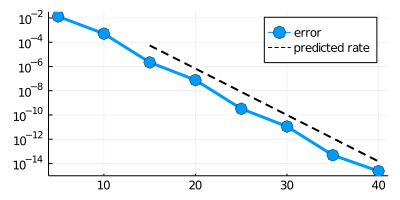

In [63]:
# You can use these tests to check the correctness of your implementation
# The autograder tests will be a bit more rigorous though; If the graph 
# reaches close to machine precision and the slope matches the "rate" then
# your implementation is probably correct.

# you can edit this test if you wish, e.g. experiment with the `c` value

# The Witch of Agnesi!
c = 1.0
f = x -> 1 / (1  + c^2 * x^2)

# The convergence rate is the ρ^{-N} where 
# 0.5 * (ρ - 1/ρ) = 1/c ⇔ ρ^2 - 2ρ/c - 1 = 0 ⇔ ρ = 1/c + sqrt(1/c^2+1)
ρ =  1/c + sqrt(1/c^2 + 1)
# To understand the origin of this calculation find the concept of the Bernstein ellipse 
# We may be able to cover this at the end of this course.      

xs = range(-1, 1, length=1_000)
fs = f.(xs)
NN = 5:5:40
err = []
for N in NN 
    X = cos.(range(0, pi, length=N))
    F = f.(X)
    W = baryweights(X)
    ps = baryeval.(xs, Ref(F), Ref(X), Ref(W))
    push!(err, norm(fs-ps, Inf))    
end
plot(NN, err, lw=3, m=:o, ms=6, label = "error", size = (400, 200), yaxis = :log10)
plot!(NN[3:end], 30*ρ.^(-NN[3:end]), lw=2, c=:black, ls=:dash, label = "predicted rate")

### Question 4 - Implement a Special Function [15]

Implement a routine 
```julia 
function mysin(x::Float64)
    # ... your code
end
```
which takes a real floating point number `x::Float64` as input and returns the value of $\sin(x)$ to within 7 digits absolute accuracy. Your function may use the operations `+, -, *, /` but may not use any special functions already implemented in Julia (such as `sqrt, exp, sin, cos, ...`). Comment the code, explaining briefly how you contructed the approximation. If you call any external function then please convince yourself that it uses only the basic arithmetic operations.

50% of the score will be for correctness, and 50% for evaluation speed. Full points for 7 digits target accuracy and evaluation time less than twice the evaluation time of the built-in `sin` function. Reduced accuracy or evaluation efficiency will lead to partial points.  If you don't score full points, then I will give up to 5 bonus points for elegance and insightful comments on your construction.

With the restriction on the arithmetic operations I allow you can only represent sin in terms of polynomials or rational functions. Use any method you like that we have covered in lectures, workshops, or in this assignment ... it is part of the question for you to figure out what you would like to use to construct your approximant.

In [ ]:
# use this cell to experiment, e.g. determine the parameters for the 
# approximant. But implement your solution in the cell below!

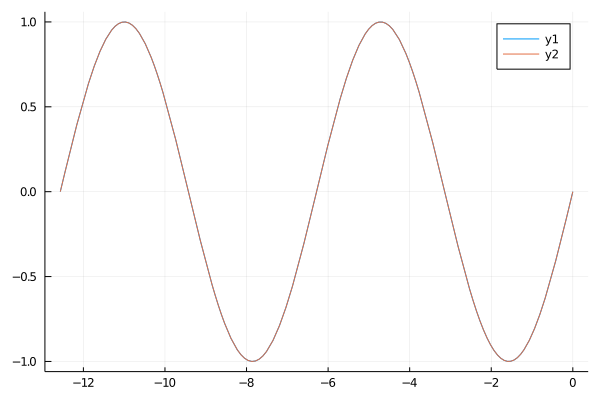

In [123]:
# # Failed Attempt using barycentric interpolation. TOO SLOW
# function mysin(x::Float64)
#     # YOUR CODE HERE
#     # Sine repeats with period 2pi
#     p = 3.14159265359
#     x = x%(2.0*p)

#     X = [0.0:p/16.0:2*p;]
#     F = sin.(X)
#     W = baryweights(X)  
#     return baryeval(x, F, X, W)
# end

function mysin(x::Float64)
    # Storing value for pi and pi/2
    p = 3.141592653589793
    p_div2 = 1.5707963267948966
    isneg = false
    
    # Sine repeats with a period of 2pi
    if x < 0.0; isneg = true; end
    x = abs(x%(2.0*p))
    
    # Sine is also symmetric around pi/2 for [0,pi] and 3pi/2 for [pi,2pi]
    # We can take advantage of these properties to increase the accuracy
    interval = trunc(x/p_div2)
    x = x%p_div2
    if interval == 1 || interval == 3
        x = p_div2 - x
    end
    
    # Computing the powers of x. 
    # Using arrays to store values or recomputing each value needed is too expensive
    x_2 = x*x
    x_3 = x*x_2
    x_5 = x_2*x_3
    x_7 = x_5*x_2
    x_9 = x_7*x_2
    x_11 = x_9*x_2
    
    # Taylor Series expansion for sin(x)        
    val = x - x_3/6.0 + x_5/120.0 - x_7/5040.0 + x_9/362880.0 - x_11/39916800.0
    if isneg == true; val = -val; end
    
    if interval == 0 || interval == 1
        return val
    else
        return -val
    end
end

plot(sin, -4pi,0)
plot!(mysin, -4pi,0)

In [124]:
# BEGIN TEST

println("Correctness")
Random.seed!(23456)
X = range(1e-7, pi/2-1e-7, length=1_000_000)
X += 6e-8 * (rand(1_000_000) .- 0.5)
err = norm(mysin.(X) - sin.(X), Inf)
println("error = $err (should be < 1e-7)")
try println(@test err < 1e-7); catch; end 

println("Timing:")
x = 0.5 + 0.5 * rand()
tsin = @belapsed sin($x)
tmysin = @belapsed mysin($x)
println("Evaluation time ratio = ", tmysin / tsin, "; (should be < 2)")
try println(@test tmysin <= 2 * tsin); catch; end 

# END TEST

Correctness
error = 5.625889010207885e-8 (should be < 1e-7)
Test Passed
Timing:
Evaluation time ratio = 0.0030428161169611; (should be < 2)
Test Passed


In [122]:
abs(-1)

1

### Question 5: Simpson Rule [5+5+5+10]

Consider the quadrature rule  (Simpson rule) 
$$ 
    \int_{-h/2}^{h/2} f(x) \,dx \approx \frac{h}{6} \big( f(-h/2) + 4 f(0) + f(h/2) \big)
$$

(a) We said that we can most quadrature rules can be interpreted as integrating a polynomial interpolant of the integrand. Which polynomial interpolant does the Simpson rule correspond to? (state without proof)

(b) Derive an error bound, assuming that $f \in C^4([a, b])$.  
[Full points for a short proof that gets within a factor 2 of the sharp bound; partial points for a proof that gets the correct order.]

(c) State (without proof) the corresponding estimate for the composite Simpson rule with mesh-size $h$.

**Part (a)** 

Simpson rule corresponds to a quadratic interpolant. It interpolates over three points [a, (a+b)/2, and b]. Interpolating over three data points leads to a polynomial of degree one less than the number of data points i.e. $P_2(x)$.

**Part (b)**

The error of the quadrature is the following. $a = -h/2$ and $b = h/2$
$$
\int_{a}^{b}f(x) - p(x) dx
$$

The integrand in the above expression is the interpolation error and as we've seen in class, we again rewrite the above like the following. Note that with Simpson's rule we are interpolating over 3 data points, so N = 2.

$$\begin{aligned}
Error &= \int_{a}^{b}\frac{f^{(N+1)}(\xi)}{(N+1)!}\prod_{i=0}^{N}(x-x_i) dx \\
&= \int_{a}^{b}\frac{f^{(3)}(\xi)}{6}(x-x_0)(x-x_1)(x-x_2) dx \\
&= \frac{f^{(3)}(\xi)}{6}\int_{a}^{b}(x-x_0)(x-x_1)(x-x_2) dx 
\end{aligned}$$

If $\prod_{i=0}^{N}(x-x_i)$ term is always non-negative or always non-positive (always on one side of the axis), we can just evaluate the above expression to determine the error. 

For Simpson rule, this isn't the case. If we substitute the interpolation points for Simpson's rule ($x_0 = a$, $x_1 = (a+b)/2$, and $x_2 = b$) to the following intergral we get zero.

$$
\int_{a}^{b}(x-x_0)(x-x_1)(x-x_2) dx = 0
$$

We can utilize this property to obtain an error function for Simpson's rule that we CAN evaluate. In order to do this we have to bring in another interpolation scheme: Newton polynomials. Given a set of N+1 data points, there is a unique polynomial of degree N. So, Newton polynomials would yield the same result as Lagrange or other interpolation methods.

Newton polynomials have a neat property that makes interpolating over additional data points straight forward. If we add an additional data point, we just need to append an extra term to the interpolant $p(x)$. Previous terms are not affected.

Let's observe the specific case of Simpson's rule.

$$
p(x) = a_0 + a_1(x-x_0) + a_2(x-x_0)(x-x_1) \\
\int_a^b p(x) dx = \int_a^b a_0 + a_1(x-x_0) + a_2(x-x_0)(x-x_1) dx
$$

I'll show that due to aforementioned structure of the Newton polynomials we can add an additional datapoint to the above expression for Simpson's rule **without** affecting the integral of p(x). Note that $a_i$ is a constant and can be taken out of the expression for the integral.

$$
p(x) = a_0 + a_1(x-x_0) + a_2(x-x_0)(x-x_1) + a_3(x-x_0)(x-x_1)(x-x_2)
$$

$$\begin{aligned}
\int_a^b p(x) dx &= \int_a^b a_0 + a_1(x-x_0) + a_2(x-x_0)(x-x_1) + a_3(x-x_0)(x-x_1)(x-x_2) dx \\
&= \int_a^b a_0 + a_1(x-x_0) + a_2(x-x_0)(x-x_1)dx + a_3 \int_a^b(x-x_0)(x-x_1)(x-x_2) dx\\
\end{aligned}$$

The second term in the above expression is what we've evaluated to be zero above. So, if we remove the second term, one can notice that the expression for the integral is same with and without the added datapoint for the Simpson rule.

So using this finding, we can now select a new data point to add in $[a,b]$ that would help us making the error function evaluatable (non-positive or non-negative).

One such selection is choosing the midpoint twice such that the points are $x_0 = a$, $x_1 = (a+b)/2$, $x_2 = (a+b)/2$, and $x_3 = b$.

In this case, if we graph $\prod_{i=0}^{N}(x-x_i) = (x-a)(x-(a+b)/2)(x-(a+b)/2)(x-b)$ we notice that it is always non-positive.

Now we can proceed with evaluating the error function (with the assistance of wolfram to evaluate the integral)

$$\begin{aligned}
Error &= \frac{f^{(4)}(\xi)}{24}\int_{a}^{b}(x-a)(x-(a+b)/2)^2(x-b) dx \\
&= \frac{f^{(4)}(\xi)}{24}\frac{(a-b)^5}{120} \\
&= \frac{f^{(4)}(\xi)(a-b)^5}{2880}
\end{aligned}$$

There we have it.

Source: 
1. http://pages.cs.wisc.edu/~amos/412/lecture-notes/lecture19.pdf 
2. https://en.wikipedia.org/wiki/Newton_polynomial

**Part (c)**

The following expression is for the composite simpson quadrature with mesh size h in an interval [a,b].
$$
|I - I_N| \leq \frac{\|f^4(\xi)\|_{\infty}}{2880}h^4(b-a)
$$

(d) Using the integral $\int_0^\pi \sin(x) \,dx = 2$ as an example, confirm the convergence rate predicted in (b), numerically. Produce a figure that compares the numerical convergence rate against the predicted rate. 

Ideally, you should first implement a function, e.g., `function simpson(f, a, b, N)` which implements the simpson rule. Then implement a short test (see lectures for inspiration!) which checks that the output of your function converges with the predicted rate to the analytic value.

0.11989476363991854
[0.12001775435648543, 0.11990043288288582, 0.11989508837534661, 0.1198947835692304, 0.11989476488001365, 0.11989476371733958]


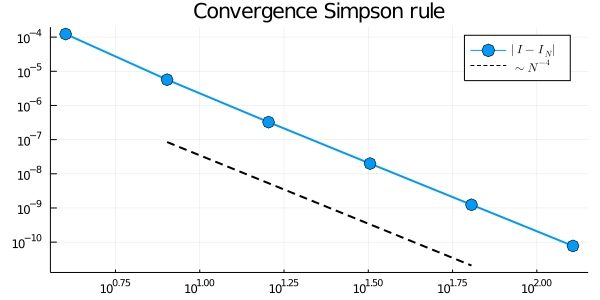

In [69]:
# solution part (d) 
# YOUR CODE HERE

function simpson(f, a, b, N)
    h = (b-a)/N
    return sum( f(x-h/2) + 4.0*f(x) + f(x+h/2) for x in range(a+h/2,b-h/2,length=N) )*h/6.0
end

f = x -> x/(1+10*x^2)
If = log(11) / 20 # CHECK THIS!!
NN = [4, 8, 16, 32, 64, 128]
If_N = [ simpson(f, 0, 1, N) for N in NN ]
println(If)
println(If_N)

plot(NN, abs.(If_N .- If), lw=2, m=:o, ms=6, label = L"|I - I_N|", 
    xaxis = :log, yaxis = :log, size = (600, 300), 
    title = "Convergence Simpson rule")
plot!(NN[2:5], (1/2880) * NN[2:5].^(-4), lw=2, ls=:dash, c=:black, label =  L"\sim N^{-4}")

My implementation of Simpson Rule does converge at the same rate as the predicted rate ($N^{-4}$). The plot for the predict rate (dotted line) is a bit distanced from the analytic value. This is likely due to a constant factor excluded from the calculations including the $f^4$ term.

## Question 6 [5+5+5+5] : integrate some functions

Integrate each of the following functions numerically. For each function you should 
* use an integrator that you implemented yourself (simpson?)
* use the `Cubature.jl` package. 
Store the solutions in the variables `I_x` (your own method) and `Icub_x` (the `Cubature.jl` solution) where `x` is `a`, `b`, ...; e.g. 
```julia
f_a = x -> exp(-x^2)
I_a = my_method(f_a, ...) 
Icub_a, err_a = hquadrature(f_a, ...)
```

(a) $f_a(x) = e^{-x^2}, x \in [0, 1]$

(b) $f_b(x) = x \log(x), x \in [0, 1]$ 

(c) $f_c(x) = \sqrt{x} \log(x), x \in [0, 1]$ 

(d) $f_d(x) = \sqrt{x} \exp(- 0.1 x), x \in [1, \infty]$

I encourage you to use brute-force rather than get too clever about manually resolving the singularities. Let the computer do the work for you.

In [79]:
using Cubature 

# YOUR CODE HERE

f_a = x -> exp(-x^2)
Iexact_a = sqrt(pi)/2*erf(1)
I_a = simpson(f_a, 0, 1, 10) 
error_a = abs(Iexact_a - I_a)
Icub_a, err_a = hquadrature(f_a, 0, 1)
@show I_a, error_a, Icub_a, err_a

f_b = x -> x*log(x)
Iexact_b = -0.25
I_b = simpson(f_b, eps(Float64), 1, 100)
error_b = abs(Iexact_b - I_b)
Icub_b, err_b = hquadrature(f_b, 0, 1)
@show I_b, error_b, Icub_b, err_b

f_c = x -> sqrt(x)*log(x)
Iexact_c = -4/9
I_c = simpson(f_c, eps(Float64), 1, 1000)
error_c = abs(Iexact_c - I_c)
Icub_c, err_c = hquadrature(f_c, 0, 1)
@show I_c, error_c, Icub_c, err_c

# Using change of variables to integrate to Inf
forig_d = x -> sqrt(x)*exp(-0.1*x)
f_d = t -> forig_d(t/(1-t))/(1-t)^2

Iexact_d = 28.025
I_d = simpson(f_d, 0, 1-eps(Float64), 1000)
error_d = abs(Iexact_d - I_d)
Icub_d, err_d = hquadrature(f_d, 0, 1)
@show I_d, error_d, Icub_d, err_d

(I_a, error_a, Icub_a, err_a) = (0.7468241838759148, 5.106348777150771e-8, 0.7468241328124271, 8.291413475940725e-15)
(I_b, error_b, Icub_b, err_b) = (-0.24999807459463733, 1.9254053626738266e-6, -0.2500000000013936, 1.4758704671426692e-9)
(I_c, error_c, Icub_c, err_c) = (-0.44443445094750866, 9.993496935756241e-6, -0.44444444444639464, 3.5460706993911613e-9)
(I_d, error_d, Icub_d, err_d) = (28.024955174507, 4.4825492999223115e-5, 28.02495608204096, 1.7589836291241602e-7)


(28.024955174507, 4.4825492999223115e-5, 28.02495608204096, 1.7589836291241602e-7)